In [49]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import seaborn as sns
import numpy

Getting the pandas dataframe from the csv file

In [3]:
data = pd.read_csv(r'Admission.csv')
print(data)

     Admission  GRE   GPA
0            0  380  3.61
1            1  660  3.67
2            1  800  4.00
3            1  640  3.19
4            0  520  2.93
..         ...  ...   ...
395          0  620  4.00
396          0  560  3.04
397          0  460  2.63
398          0  700  3.65
399          0  600  3.89

[400 rows x 3 columns]


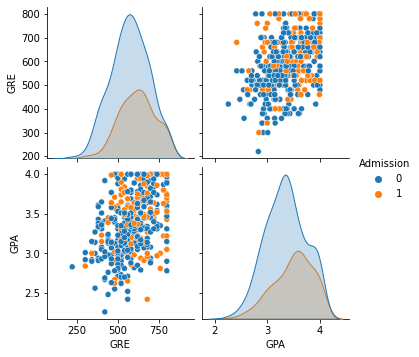

In [4]:
sns.pairplot(data, hue="Admission", diag_kind="kde")

Extracting x and y from the dataframe

In [21]:
y_real = data['Admission']
x_n = ['GRE', 'GPA']
x_real = data[x_n].values

Verifying if the data is balanced

In [6]:
print(data['Admission'].value_counts())

0    273
1    127
Name: Admission, dtype: int64


As we can see, we have an imbalaced set, Admission=1 has less instances than Admission=0.
I will use over-sampling to create a balanced set.
I will use RandomOverSampler from imblearn.over_sampling.
Reference: https://imbalanced-learn.org/stable/over_sampling.html

In [12]:
from imblearn.over_sampling import RandomOverSampler

random_over_instance = RandomOverSampler(random_state=0)

x_balanced, y_balanced = random_over_instance.fit_resample(x_real, y_real)

print(y_balanced.value_counts())

0    273
1    273
Name: Admission, dtype: int64


In [69]:
def get_model(x, y):
    with pm.Model() as model:
        α = pm.Normal('α', mu=0, sd=10)
        β = pm.Normal('β', mu=0, sd=2, shape=len(x_n))
        x_data = pm.Data('x', x)
        μ = α + pm.math.dot(x_data, β)
        θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
        bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_data[:,0])
        yl = pm.Bernoulli('yl', p=θ, observed=y)
        idata = pm.sample(2000, target_accept=0.9, return_inferencedata=True)
    return model, idata

In [165]:
def show_boundary(x, y, idata, hdi_prob=None):
    idx = np.argsort(x[:,0])
    bd = idata.posterior['bd'].mean(("chain", "draw"))[idx]
    plt.scatter(x[:,0], x[:,1], c=[f'C{x}' for x in y])
    plt.plot(x[:,0][idx], bd, color='k')
    if hdi_prob is not None:
        az.plot_hdi(x[:,0], idata.posterior['bd'], color='k', hdi_prob=hdi_prob)
    else:
        az.plot_hdi(x[:,0], idata.posterior['bd'], color='k')
    plt.xlabel(x_n[0])
    plt.ylabel(x_n[1])
    
    return list(bd)

Now we will create a model with the imbalanced(real) data and then we will compare it to the one with balanced data.

In [71]:
model_real, idata_real = get_model(x_real, y_real)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


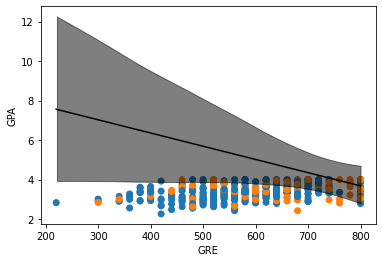

In [166]:
bdd = show_boundary(x_real, y_real, idata_real)

In [74]:
model_balanced, idata_balanced = get_model(x_balanced, y_balanced)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.


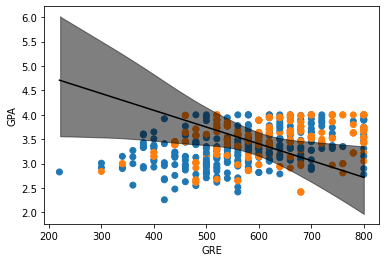

In [167]:
bd = show_boundary(x_balanced, y_balanced, idata_balanced, 0.94)

Now we will print the average value for the boundary:

In [168]:
print(numpy.array(bd).mean())

3.424045689603306


As can be observed, the uncertainty is smaller than it was with real data, but the line of decision boundary didn't change drastically. The decision boundary is now closer to our data, the model above was underfitiing our data, but this one isn't. This means that the new data was generated accordingly. Further, we will only use the balanced model, since it has a smaller level of uncertainty, so it is closer to reality.

Now we will try to infer on the model and obtain the prediction for GRE=550 and GPA=3.5.

In [178]:
def predict_for(model, idata, x):
    with model:
        pm.set_data({'x': x})
        y_test = pm.sample_posterior_predictive(idata)
        prediction = y_test['yl'].mean()
        print(f"The rounded mean is: {round(prediction)}")
        print(f"The real mean is: {prediction}")     
        # az.plot_hdi(x, y_test['yl'])

    return prediction

In [159]:
def predict_for_models(x, model_balanced, idata_balanced, model_real, idata_real):
    print("~~~~ Predicting with the model with balanced data ... ~~~~")
    prediction_balanced = predict_for(model_balanced, idata_balanced, x)
    print()
    print("~~~~ Predicting with the model with real data ... ~~~~")
    prediction_real = predict_for(model_real, idata_real, x)

In [180]:
predict_for_models([[550, 3.5]], model_balanced, idata_balanced, model_real, idata_real)

~~~~ Predicting with the model with balanced data ... ~~~~


The rounded mean is: 0
The real mean is: 0.48834271978021976

~~~~ Predicting with the model with real data ... ~~~~


The rounded mean is: 0
The real mean is: 0.3017621875


As we can see we obtained that our model has a bigger probability to predict admission as being 0 than 1. So it will say that the person won't be admitted. The model with balanced data is less sure that the person will not be admitted, but the one with real data is more sure that the person won't be admitted. 

RESPONSE: the person won't be admitted.

In [171]:
predict_for_models([[500, 3.2]], model_balanced, idata_balanced, model_real, idata_real)

~~~~ Predicting with the model with balanced data ... ~~~~


The rounded mean is: 0
The real mean is: 0.39311057692307694

~~~~ Predicting with the model with real data ... ~~~~


The rounded mean is: 0
The real mean is: 0.2328484375


We can now observe that the models have a smaller level of uncertainty in regards to the admission of the student. The student will also not be admitted, but with a higher degree of certainty.